<a href="https://colab.research.google.com/github/reulissontorres/CNN-vs-ViT/blob/main/CNN_vs_ViT-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#!pip install timm matplotlib

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import time

# Configurações (Hiperparâmetros)

In [27]:
# Se tiver GPU, usa ela. Se não, usa CPU.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64 # número de imagens que a rede processa de uma só vez antes de calcular o erro e atualizar os pesos
EPOCHS = 5 # Como o batch size é 64, em uma época a rede fará $50.000 / 64, aprox. 781 atualizações de pesos.
LEARNING_RATE = 0.001
# O dataset CIFAR-10 possui 10 categorias: avião, carro, pássaro, gato, cervo, cachorro, sapo, cavalo, navio, caminhão
NUM_CLASSES = 10

print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


# Preparação dos Dados (CIFAR-10)
Para garantir uma comparação justa, utilizei o mesmo dataset (CIFAR-10) e as mesmas transformações de imagem para os dois modelos. As imagens foram redimensionadas para 224x224 pixels, pois é a resolução padrão onde os Vision Transformers performam melhor.

In [28]:
def get_dataloaders():
    # ViTs precisa de imagens 224x224. O CIFAR é 32x32.
    # Redimensiona para garantir que as arquiteturas funcionem
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    print("Baixando e carregando CIFAR-10...")
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, test_loader

# Definição dos Modelos
Para as CNNs, escolhi a ResNet-18, que usa convoluções e skip connections. Para o Transformer, usei um ViT-Tiny (Vision Transformer). A grande diferença no código é que a CNN processa pixels vizinhos (convolução), enquanto o ViT quebra a imagem em patches (NxN pixels) e usa mecanismos de atenção global.

In [29]:
def get_model(model_name):
    if model_name == 'cnn':
        # Usa ResNet18 como representante das CNNs
        # Pretrained=False para treinar do zero e ver a curva de aprendizado
        model = torchvision.models.resnet18(weights=None)
        # Ajustar a última camada para 10 classes
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

    elif model_name == 'vit':
        # Usa ViT-Tiny do timm pq é mais leve que o Base e treina mais rápido.
        model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=NUM_CLASSES)

    return model.to(DEVICE)

#Função de Treinamento

In [30]:
def train_model(model, train_loader, test_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    history = {'loss': [], 'accuracy': []}

    print(f"\nIniciando treinamento do modelo: {model_name.upper()}")
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Avaliação rápida no dataset de teste a cada época
        acc = evaluate_model(model, test_loader)
        avg_loss = running_loss / len(train_loader)

        history['loss'].append(avg_loss)
        history['accuracy'].append(acc)

        print(f"Época [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f} - Acurácia Teste: {acc:.2f}%")

    total_time = time.time() - start_time
    print(f"Tempo total de treino ({model_name.upper()}): {total_time:.2f} segundos")

    return history, total_time

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Visualização dos Resultados

In [31]:
def plot_results(history_cnn, history_vit):
    epochs_range = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))

    # Gráfico de Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_cnn['loss'], label='CNN (ResNet18)', marker='o')
    plt.plot(epochs_range, history_vit['loss'], label='ViT (Tiny)', marker='x')
    plt.title('Curva de Perda (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_cnn['accuracy'], label='CNN (ResNet18)', marker='o')
    plt.plot(epochs_range, history_vit['accuracy'], label='ViT (Tiny)', marker='x')
    plt.title('Acurácia no Teste')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Execução principal

Baixando e carregando CIFAR-10...

Iniciando treinamento do modelo: CNN
Época [1/5] - Loss: 1.3345 - Acurácia Teste: 61.11%
Época [2/5] - Loss: 0.8235 - Acurácia Teste: 74.17%
Época [3/5] - Loss: 0.6215 - Acurácia Teste: 73.52%
Época [4/5] - Loss: 0.4916 - Acurácia Teste: 78.41%
Época [5/5] - Loss: 0.4000 - Acurácia Teste: 82.27%
Tempo total de treino (CNN): 946.35 segundos

Iniciando treinamento do modelo: VIT
Época [1/5] - Loss: 1.8895 - Acurácia Teste: 33.60%
Época [2/5] - Loss: 1.7139 - Acurácia Teste: 38.35%
Época [3/5] - Loss: 1.5939 - Acurácia Teste: 44.88%
Época [4/5] - Loss: 1.4921 - Acurácia Teste: 48.40%
Época [5/5] - Loss: 1.4199 - Acurácia Teste: 49.57%
Tempo total de treino (VIT): 1072.30 segundos

=== RESULTADOS FINAIS ===
CNN (ResNet18) - Acurácia Final: 82.27% | Tempo: 946.35s
ViT (Tiny)     - Acurácia Final: 49.57% | Tempo: 1072.30s


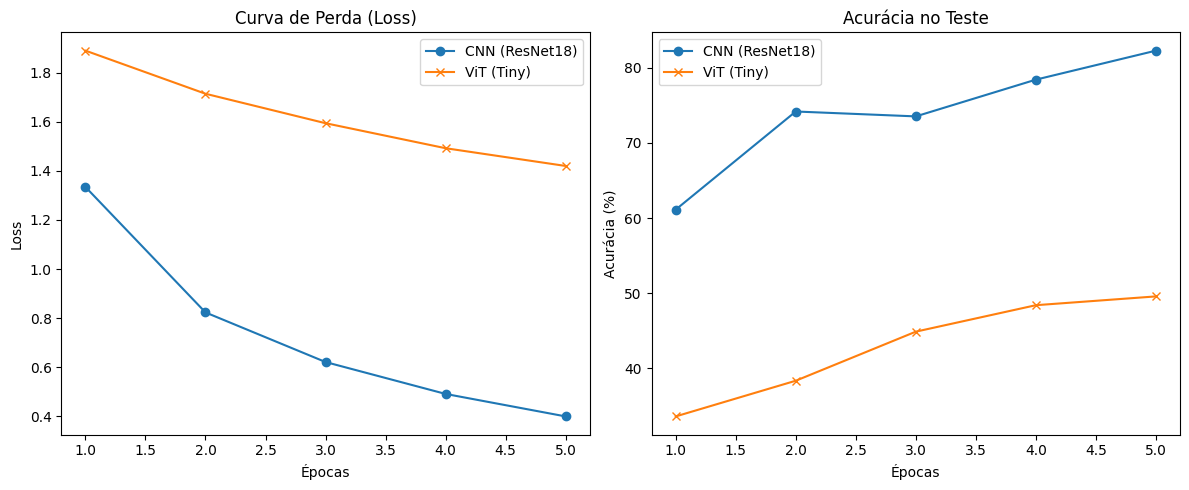

In [32]:
if __name__ == "__main__":
    # 1. Carregar Dados
    train_dl, test_dl = get_dataloaders()

    # 2. Treinar CNN
    cnn_model = get_model('cnn')
    cnn_hist, cnn_time = train_model(cnn_model, train_dl, test_dl, 'cnn')

    # 3. Treinar ViT
    # Limpamos a memória da GPU antes de treinar o próximo
    torch.cuda.empty_cache()

    vit_model = get_model('vit')
    vit_hist, vit_time = train_model(vit_model, train_dl, test_dl, 'vit')

    # 4. Comparar Resultados
    print("\n=== RESULTADOS FINAIS ===")
    print(f"CNN (ResNet18) - Acurácia Final: {cnn_hist['accuracy'][-1]:.2f}% | Tempo: {cnn_time:.2f}s")
    print(f"ViT (Tiny)     - Acurácia Final: {vit_hist['accuracy'][-1]:.2f}% | Tempo: {vit_time:.2f}s")

    plot_results(cnn_hist, vit_hist)